In [38]:
from dotenv import load_dotenv

load_dotenv()

True

In [39]:
%pip install -U ddgs

Note: you may need to restart the kernel to use updated packages.


In [40]:
%pip install -qU "langchain-google-community[gmail]"

Note: you may need to restart the kernel to use updated packages.


In [41]:
%pip install --upgrade --quiet langchain-community arxiv

Note: you may need to restart the kernel to use updated packages.


In [42]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0)
small_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [43]:
from langchain_core.tools import tool


@tool
def add(a: int, b: int) -> int:
    """Add two numbers."""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b

In [44]:
from langchain_community.tools import DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun()

In [45]:
from langchain_google_community import GmailToolkit
from langchain_google_community.gmail.utils import (
  build_resource_service,
  get_gmail_credentials
)

SCOPES = [
    "https://www.googleapis.com/auth/gmail.readonly",
    "https://www.googleapis.com/auth/gmail.compose",
    "https://www.googleapis.com/auth/gmail.send",
]

credentials = get_gmail_credentials(
    token_file="./google/gmail_token.json",
    scopes=SCOPES,
    client_sercret_file="./google/gmail_credentials.json",
)

api_resource = build_resource_service(credentials=credentials)
gmail_toolKit = GmailToolkit(api_resource=api_resource)
gmail_tool_list = gmail_toolKit.get_tools()

C:\Users\jo\AppData\Local\Temp\ipykernel_36088\523952650.py:13: DeprecationWarning: get_gmail_credentials is deprecated and will be removed in a future version.Use get_google_credentials instead.
  credentials = get_gmail_credentials(
C:\Users\jo\AppData\Local\Temp\ipykernel_36088\523952650.py:19: DeprecationWarning: build_resource_service is deprecated and will be removed in a future version.Use build_gmail_service instead.
  api_resource = build_resource_service(credentials=credentials)


In [46]:
from langchain_community.agent_toolkits.load_tools import load_tools

loaded_tool_list = load_tools(
  ["arxiv"]
)

In [ ]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools.retriever import create_retriever_tool

embedding_function = OpenAIEmbeddings(model="text-embedding-3-large")
vector_store = Chroma(
  embedding_function=embedding_function,
  collection_name="real_estate_tax",
  persist_directory="./chroma_db"  # ✅ 디렉터리
)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})
retriever_tool = create_retriever_tool(
  retriever=retriever,
  name='real_estate_tax_retriever',
  description='Useful for answering questions about real estate tax in South Korea.'
)

In [47]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiply, search_tool] + gmail_tool_list + loaded_tool_list
llm_with_tools = llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

In [48]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [49]:
def agent(state: MessagesState) :
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {'messages' : [response]}

In [50]:
from langgraph.graph import END

def should_continue(state : MessagesState):
    message = state['messages']
    last_ai_message = message[-1]
    if last_ai_message.tool_calls:
        return 'tools'
    return END

In [51]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)

In [52]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
  'agent',
  should_continue,
  ['tools', END]
)
graph_builder.add_edge('tools', 'agent')

In [53]:
graph = graph_builder.compile()

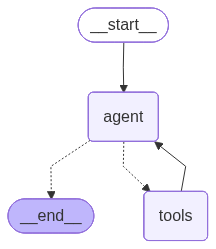

In [54]:
from IPython.display import Image, display

png_bytes = graph.get_graph().draw_mermaid_png()
display(Image(data=png_bytes))

In [55]:
from langchain_core.messages import HumanMessage
query = 'Attention Is All You Need라는 논문을 요약해서 nicednjsdud@gmail.com으로 메일 보내주세요.'
for chunk in graph.stream({'messages': [HumanMessage(query)]}, stream_mode='values') :
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

Attention Is All You Need라는 논문을 요약해서 nicednjsdud@gmail.com으로 메일 보내주세요.
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_m95C4oV9zrvsz3528a4o7afJ)
 Call ID: call_m95C4oV9zrvsz3528a4o7afJ
  Args:
    query: Attention Is All You Need
================================= Tool Message =================================
Name: arxiv

Published: 2021-05-06
Title: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet
Authors: Luke Melas-Kyriazi
Summary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifically, we replace the attention lay